# 29회차 기출문제


## 문제 1

**Data description**

임대아파트 입주자 퇴거여부 예측을 위한 데이터입니다.

-   **순번**: 데이터의 순서를 나타내는 고유 번호
-   **계약구분**: 계약의 유형(예: 유효, 해지)
-   **재계약횟수**: 재계약이 이루어진 횟수
-   **거주개월**: 해당 아파트에 거주한 총 개월 수
-   **아파트 이름**: 아파트의 이름
-   **아파트 ID**: 아파트를 식별하는 고유 ID
-   **아파트 평점**: 아파트의 평점
-   **호실고유번호**: 아파트의 특정 호실을 식별하는 고유 번호
-   **층**: 거주하고 있는 층수
-   **평형대**: 아파트의 면적(평수)
-   **계약자고유번호**: 계약자를 식별하는 고유 번호
-   **계약서고유번호**: 계약서를 식별하는 고유 번호
-   **입주연도**: 처음 입주한 연도
-   **퇴거연도**: 퇴거한 연도
-   **거주연도**: 거주한 총 연도 수
-   **월세(원)**: 월세 금액
-   **보증금(원)**: 보증금 금액
-   **대표나이**: 대표 거주자의 나이
-   **나이**: 개별 거주자의 나이
-   **성별**: 개별 거주자의 성별(예: 남, 여)
-   **결혼여부**: 개별 거주자의 결혼 여부(예: 미혼, 기혼)
-   **거주자 수**: 해당 호실에 거주하는 총 인원 수
-   **퇴거 여부(target)**: 퇴거 여부(예: 미퇴거, 퇴거)

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV, KFold
from sklearn import set_config
import xgboost as xgb
from collections import Counter
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, balanced_accuracy_score, plot_roc_curve, roc_auc_score, roc_curve, f1_score
from sklearn import set_config
set_config(display="diagram")
import warnings
warnings.filterwarnings('ignore')

In [2]:
dat = pd.read_csv('problem1.csv')

In [3]:
dat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86904 entries, 0 to 86903
Data columns (total 23 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   순번       86904 non-null  int64  
 1   계약구분     86396 non-null  object 
 2   재계약횟수    86904 non-null  int64  
 3   거주개월     86904 non-null  int64  
 4   아파트 이름   86904 non-null  object 
 5   아파트 ID   86904 non-null  int64  
 6   아파트 평점   85679 non-null  float64
 7   호실고유번호   86904 non-null  int64  
 8   층        86904 non-null  int64  
 9   평형대      86904 non-null  int64  
 10  계약자고유번호  86904 non-null  int64  
 11  계약서고유번호  86904 non-null  int64  
 12  입주연도     86904 non-null  int64  
 13  퇴거연도     25762 non-null  float64
 14  거주연도     86904 non-null  int64  
 15  월세(원)    86904 non-null  float64
 16  보증금(원)   86904 non-null  int64  
 17  대표나이     86904 non-null  int64  
 18  나이       86904 non-null  int64  
 19  성별       86904 non-null  object 
 20  결혼여부     86904 non-null  object 
 21  거주자 수    869

1.  **계약자고유번호를 기준으로 거주연도 별 여러개의 데이터가 쌓여 있다. 각 계약자고유번호에 대해 가장 최신의 거주연도 행만 남기시오.**

In [4]:
dat = (dat
    .groupby(['계약자고유번호'])
    .apply(lambda x: x.loc[x["거주연도"].idxmax()])
)

2.  **결측치를 처리하시오.**

In [5]:
miss_cnt = dat.isna().sum()
miss_ratio = miss_cnt / len(dat)
print(miss_ratio)

순번         0.000000
계약구분       0.005895
재계약횟수      0.000000
거주개월       0.000000
아파트 이름     0.000000
아파트 ID     0.000000
아파트 평점     0.013529
호실고유번호     0.000000
층          0.000000
평형대        0.000000
계약자고유번호    0.000000
계약서고유번호    0.000000
입주연도       0.000000
퇴거연도       0.604561
거주연도       0.000000
월세(원)      0.000000
보증금(원)     0.000000
대표나이       0.000000
나이         0.000000
성별         0.000000
결혼여부       0.000000
거주자 수      0.000000
퇴거여부       0.000000
dtype: float64


계약 구분, 아파트 평점 칼럼의 경우 전체 데이터의 약 1% 미만이므로, 결측치를 제거한다.

In [6]:
dat = dat.loc[(dat['아파트 평점'].notna()) & (dat['계약구분'].notna())]

In [7]:
dat.loc[dat['퇴거연도'].isna(), :].head(2)

,순번,계약구분,재계약횟수,거주개월,아파트 이름,아파트 ID,아파트 평점,호실고유번호,층,평형대,...,퇴거연도,거주연도,월세(원),보증금(원),대표나이,나이,성별,결혼여부,거주자 수,퇴거여부
계약자고유번호,,,,,,,,,,,,,,,,,,,,,
14,12702,유효,10,237,지산5단지아파트,3,8.0,85576,7,15,...,NaN,2020,81600.0,5598000,67,66,남,미혼,1,미퇴거
27,12789,유효,10,227,지산5단지아파트,3,8.0,86179,10,19,...,NaN,2020,66600.0,3116000,61,60,남,기혼,3,미퇴거


퇴거연도 칼럼의 경우 해당 거주자가 퇴거를 안했을 때, 결측치가 생성된다. 퇴거여부 칼럼과 거주개월 칼럼이 존재하므로, 두 칼럼을 통해 퇴거연도를 유추할 수 있다. 따라서 퇴거연도 칼럼을 제거한다.

In [8]:
dat = dat.drop(['퇴거연도'], axis = 1)

3.  **이상치를 처리하시오.**

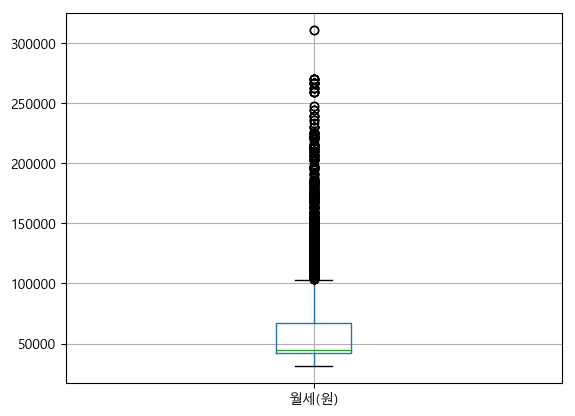

In [9]:
import koreanize_matplotlib 
plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows용
plt.rcParams['axes.unicode_minus'] = False     # 마이너스 기호 깨짐 방지
dat.loc[:, ['월세(원)']].boxplot()
plt.show();

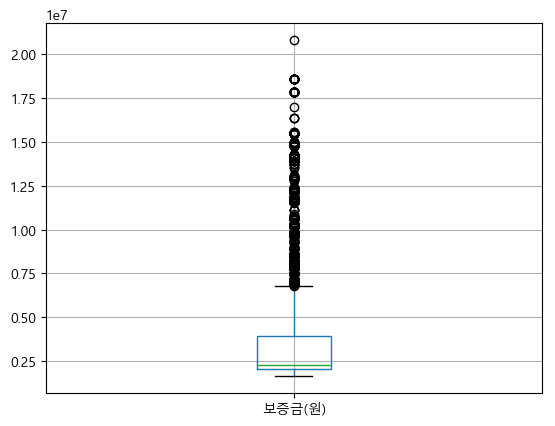

In [10]:
dat.loc[:, ['보증금(원)']].boxplot()
plt.show();

보증금, 월세 칼럼의 경우 상자그림을 기준으로 이상치가 존재한다.

In [11]:
# 1분위수 계산
Q1 = np.quantile(dat['월세(원)'], 0.25)
# 3분위수 계산
Q3 = np.quantile(dat['월세(원)'], 0.75)
IQR = Q3 - Q1

UC = Q3 + (1.5 * IQR) # 위 울타리
LC = Q3 - (1.5 * IQR) # 위 울타리
outlier1 = dat.loc[(dat['월세(원)'] > UC) | (dat['월세(원)'] < LC), :].index.tolist()

In [12]:
# 1분위수 계산
Q1 = np.quantile(dat['보증금(원)'], 0.25)
# 3분위수 계산
Q3 = np.quantile(dat['보증금(원)'], 0.75)
IQR = Q3 - Q1

UC = Q3 + (1.5 * IQR) # 위 울타리
LC = Q3 - (1.5 * IQR) # 위 울타리
outlier2 = dat.loc[(dat['보증금(원)'] > UC) | (dat['보증금(원)'] < LC), :].index.tolist()

In [13]:
dat2 = dat.copy()
dat2 = dat2.assign(outlier = np.where(dat2.index.isin(outlier1) | dat2.index.isin(outlier2), 1, 0))

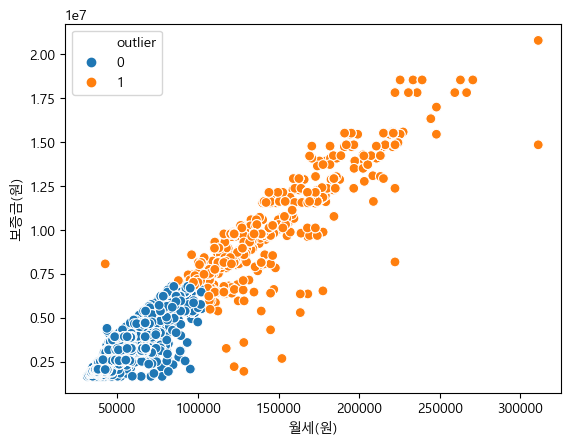

In [14]:
sns.scatterplot(x='월세(원)', 
                y='보증금(원)', 
                hue='outlier',
                s=50, # marker size
                data=dat2)
plt.show();

보증금, 월세 칼럼의 이상치는 주황색으로 표시했다. 보증금, 월세의 경우 지역별, 주변환경, 경제 요인 등 외부 요인에 따라 차이가 있을 수 있다. 따라서 이상치를 제거하지 않는다.

4.  **재계약 횟수의 중앙값을 기준으로 중앙값보다 크거나 같으면 '높음', 작으면 '낮음' 으로 하는 이분 변수를 구성하시오.**

데이터 전처리 이전에 훈련 데이터와 테스트 데이터를 분할한다. 무작위 샘플링을 통해 훈련 데이터와 테스트 데이터를 7:3으로 분할한다.

In [15]:
y = dat['재계약횟수']
X = dat.drop(['재계약횟수'], axis = 1)

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.3, shuffle = True, random_state = 0)

훈련 데이터 기준 재계약 횟수의 중앙값을 기준으로 이분 변수(score_index)를 생성한다.

In [16]:
cutoff = train_y.median()
train_X['outcome_index'] = np.where(train_y >= cutoff, '높음', '낮음')
test_X['outcome_index'] = np.where(test_y >= cutoff, '높음', '낮음')

5.  **차원축소의 필요성을 논하고, 필요에 따라 차원을 축소하고 불필요하다면 그 근거를 논하시오.**

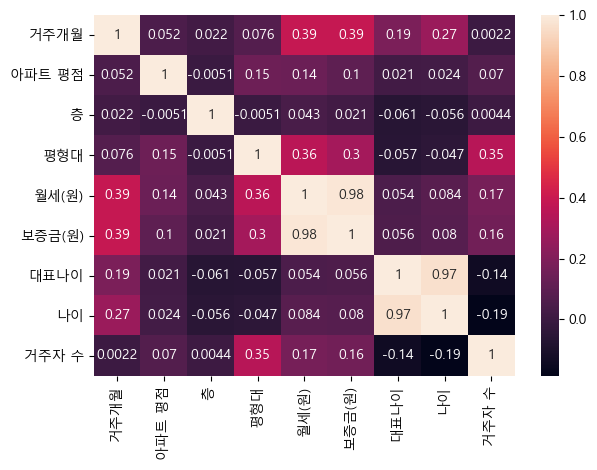

In [17]:
num_columns = ['거주개월', '아파트 평점', '층', '평형대', '월세(원)', '보증금(원)', '대표나이', '나이', '거주자 수']
corr = train_X[num_columns].corr()
sns.heatmap(corr, annot = True);
plt.tight_layout()
plt.show();

차원 축소는 변수 간의 중복 정보 제거, 연산 속도 향상, 지도학습 모델 구축시 과적합 방지를 위해 활용할 수 있다. 차원 축소 기법 중 대표적인 방법으로 주성분분석(PCA)이 있으며, 차원 축소의 필요성은 각 변수 간의 상관관계를 보고 판단할 수 있다. EDA 과정에서 확인한 결과 (`월세`, `보증금`), (`입주연도`, `거주개월`), (`대표나이`, `나이`) 칼럼을 제외하면 변수 간 상관관계가 높지 않다. 따라서 차원 축소 고려하지 않는다.

6.  **재계약 횟수 이분 변수를 활용하여 세그먼트를 구분하고 각 세그먼트의 특징을 분석하시오.**

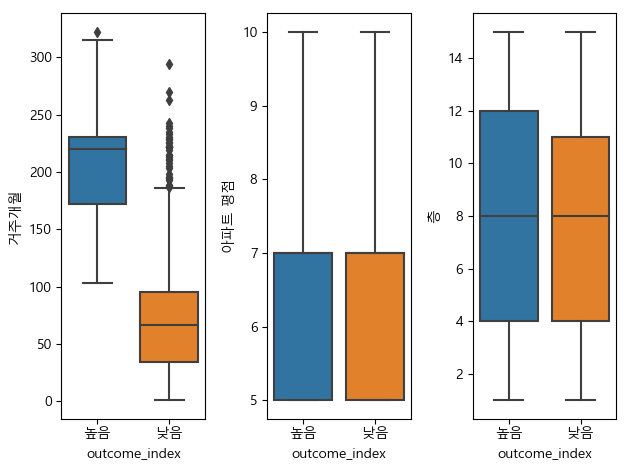

In [18]:
f, axes = plt.subplots(ncols = 3)
sns.boxplot(x = "outcome_index", y = "거주개월", data = train_X, ax = axes[0])
sns.boxplot(x = "outcome_index", y = "아파트 평점", data = train_X, ax = axes[1])
sns.boxplot(x = "outcome_index", y = "층", data = train_X, ax = axes[2])
plt.tight_layout()
plt.show();

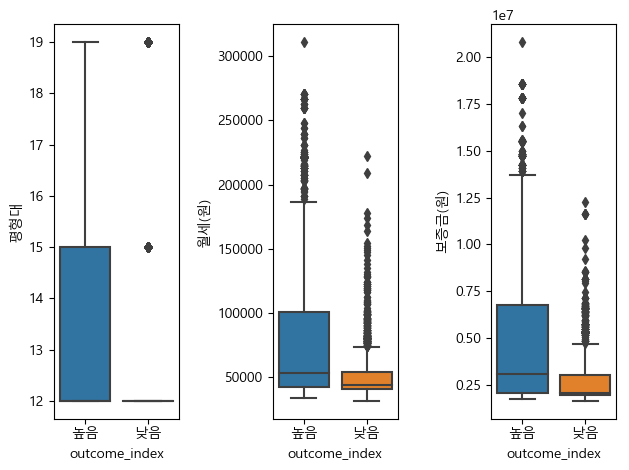

In [19]:
f, axes = plt.subplots(ncols = 3)
sns.boxplot(x = "outcome_index", y = "평형대", data = train_X, ax = axes[0])
sns.boxplot(x = "outcome_index", y = "월세(원)", data = train_X, ax = axes[1])
sns.boxplot(x = "outcome_index", y = "보증금(원)", data = train_X, ax = axes[2])
plt.tight_layout()
plt.show();

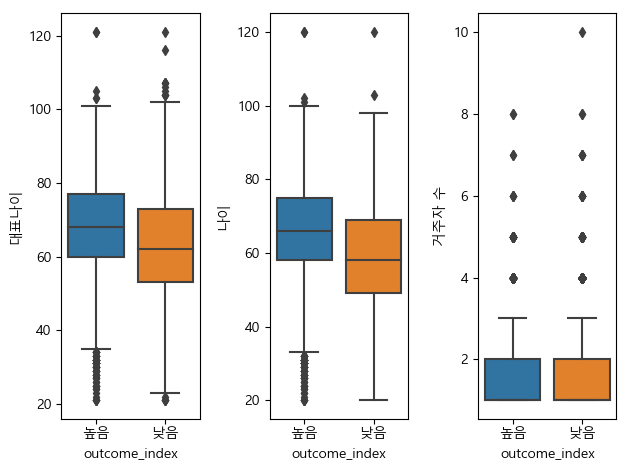

In [20]:
f, axes = plt.subplots(ncols = 3)
sns.boxplot(x = "outcome_index", y = "대표나이", data = train_X, ax = axes[0])
sns.boxplot(x = "outcome_index", y = "나이", data = train_X, ax = axes[1])
sns.boxplot(x = "outcome_index", y = "거주자 수", data = train_X, ax = axes[2])
plt.tight_layout()
plt.show();

-   재계약횟수가 '높음'인 경우 거주 개월 수도 높은 경향이 있다.

-   재계약횟수가 '낮음'인 경우 평형대는 대부분 12평대인 경향이 있음

-   재계약횟수가 '높음'인 경우 월세가 높은 경향이 있음

-   재계약횟수가 '높음'인 경우 보증금이 높은 경향이 있음

-   재계약횟수가 '높음'인 경우 거주 나이대는 높은 경향이 있음

-   재계약횟수가 '높음'인 경우 대표자 나이대는 높은 경향이 있음

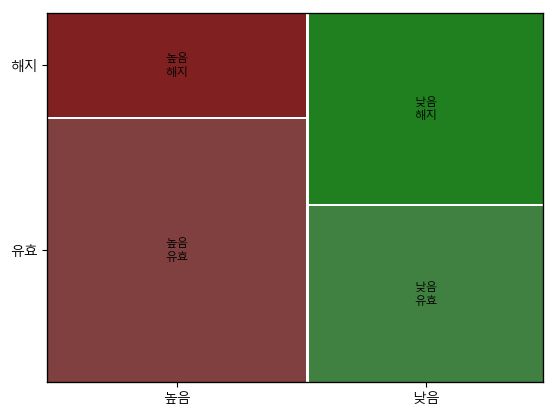

In [21]:
from statsmodels.graphics.mosaicplot import mosaic
mosaic(train_X, ['outcome_index', '계약구분'])
plt.show();

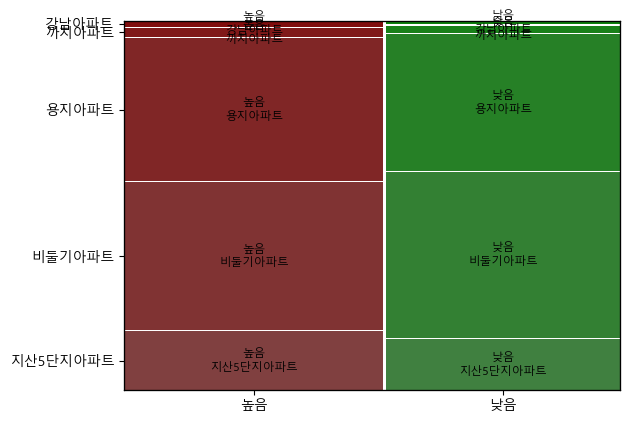

In [22]:
from statsmodels.graphics.mosaicplot import mosaic
mosaic(train_X, ['outcome_index', '아파트 이름'])
plt.show();

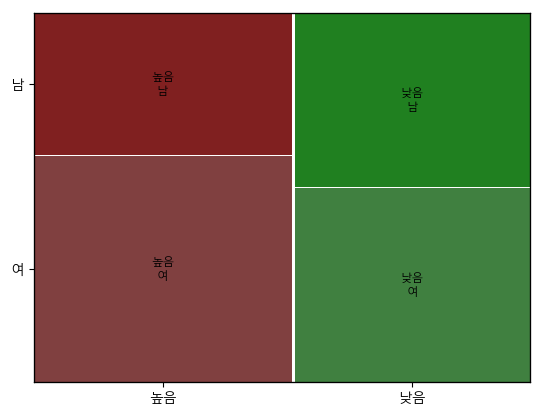

In [23]:
from statsmodels.graphics.mosaicplot import mosaic
mosaic(train_X, ['outcome_index', '성별'])
plt.show();

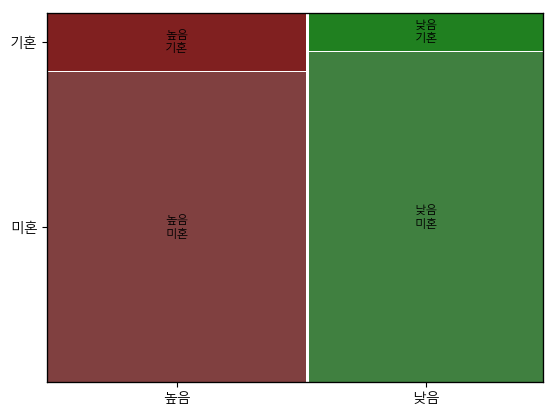

In [24]:
from statsmodels.graphics.mosaicplot import mosaic
mosaic(train_X, ['outcome_index', '결혼여부'])
plt.show();

-   재계약 횟수 이분 변수와 결혼 여부 변수 간에는 연관성이 존재하지 않음

-   재계약 횟수가 '높음'인 경우 계약 구분이 '해지'인 비율이 적음

7.  **재계약 횟수 이분 변수를 종속변수로 하는 회귀 분석을 두 가지 이상의 방법론을 통해 수행하고 최종 모델을 결정하시오.**

모델 적합 전 `아파트 ID`, `호실고유번호`, `계약서고유번호`, `재계약횟수`, `계약자고유번호` 칼럼을 삭제한다.

In [25]:
train_y = train_X['outcome_index']
test_y = test_X['outcome_index']

train_X = train_X.drop(['outcome_index'], axis = 1)
test_X = test_X.drop(['outcome_index'], axis = 1)

num_columns = ['거주개월', '아파트 평점', '층', '평형대', '월세(원)', '보증금(원)', '대표나이', '나이', '거주자 수']

cat_columns = train_X.select_dtypes('object').columns

범주형 변수에 대해서 원핫 인코딩, 연속형 변수에 대해서는 표준화를 적용한다.

In [26]:
encoding_preprocess = make_pipeline(
    OneHotEncoder(handle_unknown="ignore", sparse=False)
)

num_preprocess = make_pipeline(
    StandardScaler()
)

preprocess = ColumnTransformer(
    [("num_process", num_preprocess, num_columns), 
    ("cat_process", encoding_preprocess, cat_columns)]
    , remainder='passthrough'
)

모델 비교 및 평가를 위해 5-fold 교차 검증 방법을 적용한다. 5-fold 교차 검증은 훈련 데이터를 임의의 거의 동일한 크기의 5개 그룹(fold)으로 나누는 리샘플링 방법이다.

세부 방법은 다음과 같다.

1.  각 fold 중 $1$ fold는 validation셋으로 취급하고, 나머지 $k-1$개의 fold는 훈련 데이터로 모델 적합에 이용

2.  이러한 절차는 $k$번 반복되며, 매번 다른 그룹의 fold가 validation 셋으로 취급됨

3.  총 $k$ 개의 추정치(ex. MSE)가 계산되며, 최종 CV 추정치는 $k$ 개의 추정치를 평균내서 계산됨

In [27]:
from sklearn.ensemble import RandomForestClassifier

pipe_rf = Pipeline(
    [
        ("preprocess", preprocess),
        ("classifier", RandomForestClassifier())
    ]
)

RandomForest_param = {'classifier__max_features': np.arange(0.1, 1, 0.1)}
cv = KFold(n_splits = 5, shuffle = True, random_state = 0)

start_time = time.time()
RandomForest_search = GridSearchCV(estimator = pipe_rf, 
                      param_grid = RandomForest_param, 
                      cv = cv,
                      scoring = 'accuracy') # roc_auc, average_precision
RandomForest_search.fit(train_X, train_y)
print('Random Forest best score : ', RandomForest_search.best_score_)

Random Forest best score :  0.9736723791021994


In [28]:
from sklearn.tree import DecisionTreeClassifier

pipe_dt = Pipeline(
    [
        ("preprocess", preprocess),
        ("classifier", DecisionTreeClassifier())
    ]
)

decisiontree_param = {'classifier__ccp_alpha': np.arange(0.1, 1, 0.1)}
cv = KFold(n_splits = 5, shuffle = True, random_state = 0)

start_time = time.time()
decisiontree_search = GridSearchCV(estimator = pipe_dt, 
                      param_grid = decisiontree_param, 
                      cv = cv,
                      scoring = 'accuracy')
decisiontree_search.fit(train_X, train_y)

print('decision tree best score : ', decisiontree_search.best_score_)

decision tree best score :  0.9594525775341705


모델별로 Accyracy를 비교해보면 랜덤포레스트모형의 성능이 우수한 것을 확인할 수 있다. 따라서 최종 모형으로 랜덤포레스트 모형을 선택한다.

In [29]:
pred_rf = RandomForest_search.predict(test_X)
print(classification_report(test_y, pred_rf))
print(balanced_accuracy_score(test_y, pred_rf))

              precision    recall  f1-score   support

          낮음       0.99      0.97      0.98      1480
          높음       0.97      0.99      0.98      1565

    accuracy                           0.98      3045
   macro avg       0.98      0.98      0.98      3045
weighted avg       0.98      0.98      0.98      3045

0.9792742422934116


최종 테스트 데이터에서의 Accuracy는 0.97 수준인 것을 확인할 수 있다.

8.  **최종 채택한 모델에서 각각 유의하게 작용하는 변수를 확인하고 설명하시오.**

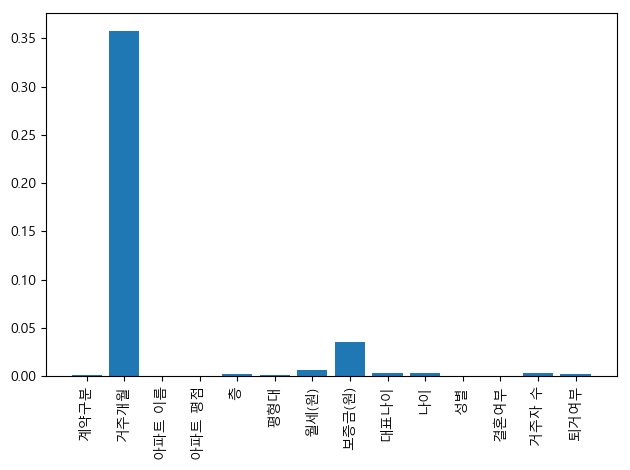

In [30]:
from sklearn.inspection import permutation_importance

feature_importances = permutation_importance(
    RandomForest_search, train_X, train_y, n_repeats=10, random_state=42
)

features = train_X.columns
importances = feature_importances.importances_mean

col_ind = num_columns + cat_columns.to_list()

f_imp = pd.DataFrame({'변수중요도' : importances, '변수' : features})
f_imp = f_imp.loc[f_imp['변수'].isin(col_ind), :]

plt.bar(f_imp['변수'], f_imp['변수중요도'])
plt.xticks(rotation=90)
plt.tight_layout()
plt.show();

거주개월, 보증금 변수 등의 변수중요도가 높은 것을 확인할 수 있다.

9.  **해당 데이터 분석결과로 얻을 수 있는 점을 제시하시오.**

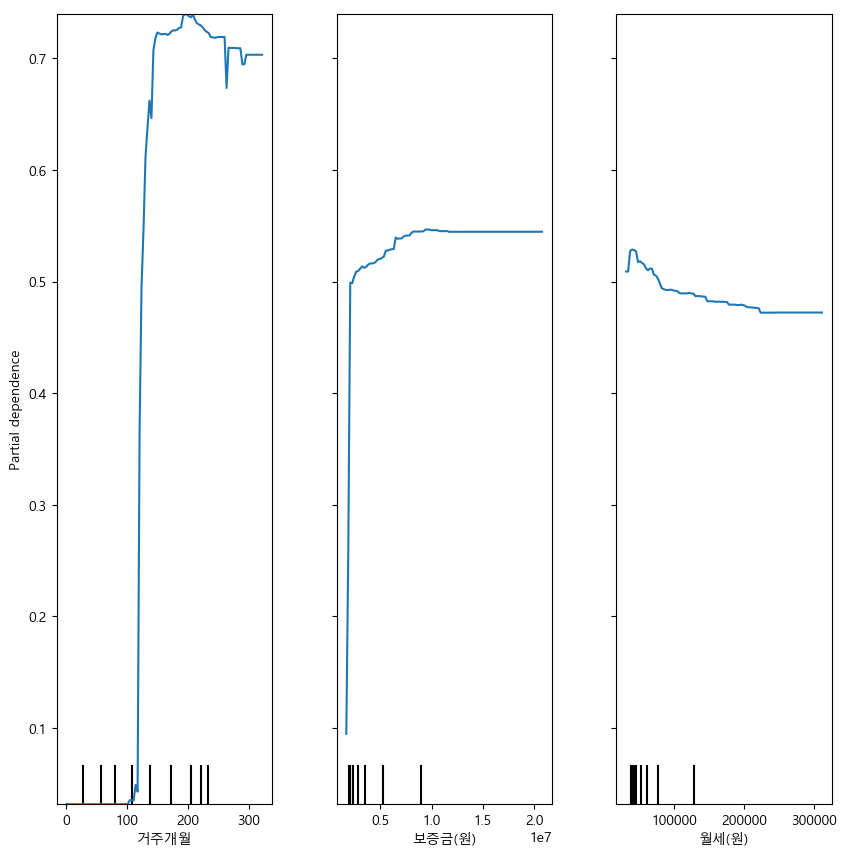

In [31]:
from sklearn.inspection import partial_dependence
from sklearn.inspection import plot_partial_dependence

fig, ax = plt.subplots(figsize=(10, 10))
#plt.subplots_adjust(top=0.9)
plot_partial_dependence(estimator=RandomForest_search, 
                        X=train_X, 
                        features=['거주개월', '보증금(원)', '월세(원)'], # 관심변수 
                        percentiles=(0, 1), # 최소, 최대 
                        ax=ax)
                        
plt.subplots_adjust(top=0.9, hspace = 0.5, wspace = 0.3) # hspace : 서브 플랏 행 간 간격 조절                      
plt.show();

변수중요도가 높은 거주개월, 입주연도, 보증금, 월세 변수에 대해서 partial dependence plot을 통해 재계약횟수(높음, 낮음) 와의 관계를 확인한다.

-   거주개월이 100을 넘어갈 경우 재계약횟수(높음)일 확률이 높아짐

-   보증금이 올라갈수록 재계약횟수(높음)일 확률이 높아짐

-   월세가 높아질수록 재계약횟수(높음)일 확률이 낮아짐

-   입주연도가 과거부터 현재에 가까워질수록 재계약횟수(높음)일 확률이 높아짐

보증금을 올리고, 월세를 낮추는 방식으로 운영한다면 재계약 비율을 높일 수 있다. 또한, 장기 거주 고객에게 프로모션을 제공하면 재계약 비율을 높힐 수 있을 것으로 기대된다.

## 문제 2

**Data description**

경기 당 9이닝 동안 1번 타자, 2번 타자의 출루 정보를 기록한 데이터입니다.

**수치 상세 내용**

-   **1: 1루타**

-   **2: 2루타**

-   **3: 3루타**

-   **4: 홈런**

-   **5: 삼진 제외 모든 아웃**

-   **6: 볼넷**

-   **7: 삼진**

-   **8: 몸에 맞는 공**

-   **9: 희생 번트**

**타자 행동**

| 컬럼명   | 의미 (회 == 이닝)  |
|----------|--------------------|
| **a1_1** | 1회 첫 타자 행동   |
| **a1_2** | 1회 둘째 타자 행동 |
| **a2_1** | 2회 첫 타자 행동   |
| **a2_2** | 2회 둘째 타자 행동 |
| **a3_1** | 3회 첫 타자 행동   |
| **a3_2** | 3회 둘째 타자 행동 |
| **a4_1** | 4회 첫 타자 행동   |
| **a4_2** | 4회 둘째 타자 행동 |
| **a5_1** | 5회 첫 타자 행동   |
| **a5_2** | 5회 둘째 타자 행동 |
| **a6_1** | 6회 첫 타자 행동   |
| **a6_2** | 6회 둘째 타자 행동 |
| **a7_1** | 7회 첫 타자 행동   |
| **a7_2** | 7회 둘째 타자 행동 |
| **a8_1** | 8회 첫 타자 행동   |
| **a8_2** | 8회 둘째 타자 행동 |
| **a9_1** | 9회 첫 타자 행동   |
| **a9_2** | 9회 둘째 타자 행동 |

#### **득점**

| 컬럼명 | 의미 (회 == 이닝) |
|--------|-------------------|
| **b1** | 1회 총 득점수     |
| **b2** | 2회 총 득점수     |
| **b3** | 3회 총 득점수     |
| **b4** | 4회 총 득점수     |
| **b5** | 5회 총 득점수     |
| **b6** | 6회 총 득점수     |
| **b7** | 7회 총 득점수     |
| **b8** | 8회 총 득점수     |
| **b9** | 9회 총 득점수     |

In [32]:
dat = pd.read_csv('problem2.csv')

1.  **각 회차별로 1번 타자의 출루 (1,2,3루타와 사사구(볼넷, 몸에맞는공))가 있는 경우에 대해 득점이 발생 했는지 확인하고자 한다. 이를 위한 전처리를 수행하시오. (단, 첫 번째 혹은 두 번째 타자가 홈런을 친 경우 해당 회차 데이터 제외)**

In [33]:
dat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 28 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   game_id  200 non-null    int64  
 1   a1_1     188 non-null    float64
 2   a1_2     200 non-null    int64  
 3   a2_1     200 non-null    object 
 4   a2_2     200 non-null    int64  
 5   a3_1     200 non-null    int64  
 6   a3_2     200 non-null    int64  
 7   a4_1     200 non-null    object 
 8   a4_2     200 non-null    int64  
 9   a5_1     200 non-null    int64  
 10  a5_2     200 non-null    int64  
 11  a6_1     200 non-null    int64  
 12  a6_2     200 non-null    int64  
 13  a7_1     200 non-null    object 
 14  a7_2     200 non-null    int64  
 15  a8_1     200 non-null    int64  
 16  a8_2     200 non-null    int64  
 17  a9_1     200 non-null    int64  
 18  a9_2     200 non-null    int64  
 19  b1       200 non-null    int64  
 20  b2       200 non-null    int64  
 21  b3       200 non

In [34]:
dat.isna().sum()

game_id     0
a1_1       12
a1_2        0
a2_1        0
a2_2        0
a3_1        0
a3_2        0
a4_1        0
a4_2        0
a5_1        0
a5_2        0
a6_1        0
a6_2        0
a7_1        0
a7_2        0
a8_1        0
a8_2        0
a9_1        0
a9_2        0
b1          0
b2          0
b3          0
b4          0
b5          0
b6          0
b7          0
b8          0
b9          0
dtype: int64

a1_1(1회 첫 타자의 행동) 칼럼에 결측치가 12개 존재한다. 야구 특성상 이닝별, 특정 게임별로 타자의 컨디션이 다르므로, a1_1(1회 첫 타자의 행동) 변수의 결측치를 대치하는 것은 부적절할 수 있다. 따라서 결측치를 삭제한다.

In [35]:
dat = dat.loc[dat.a1_1.notna(), :]

In [36]:
dat.a2_1.value_counts()
dat.a4_1.value_counts()
dat.a7_1.value_counts()

5    63
7    41
1    27
6    22
2    18
4    10
"     3
8     2
3     2
Name: a7_1, dtype: int64

a2_1, a4_1, a7_1 칼럼에 특수문자가 존재한다. 특수문자는 라벨링 오류로 판단하여 삭제한다.

In [37]:
#dat.shape
dat = dat.loc[dat.a2_1 != ':', :]
dat = dat.loc[dat.a4_1 != '&', :]
dat = dat.loc[dat.a7_1 != '"', :]

In [38]:
dat = dat.astype({'a2_1' : 'int64', 'a4_1' : 'int64', 'a7_1' : 'int64', 'a1_1' : 'int64'})

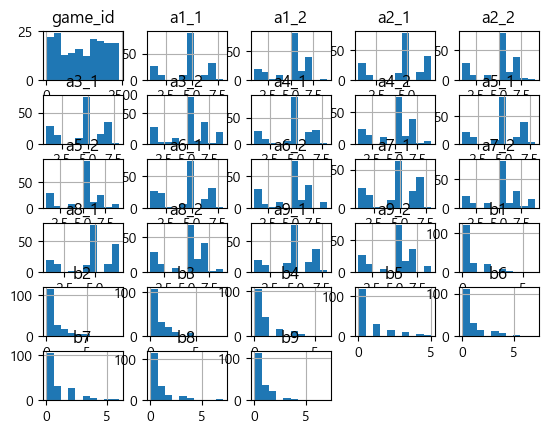

In [39]:
dat.hist()
#plt.tight_layout()
plt.show();

모든 칼럼의 히스토그램을 확인했을 때, 결측치 및 이상치가 제거된 것을 확인할 수 있다. 데이터 전처리를 위해 데이터 구조를 변환한다.

In [40]:
sub_dat1 = pd.melt(dat, 
                   id_vars = ['game_id'], 
                   value_vars = dat.columns[dat.columns.str.endswith('_1')],
                   var_name = 'ining1', 
                   value_name = 'first_move', 
                   ignore_index = False)


sub_dat2 = pd.melt(dat, 
                   id_vars = ['game_id'], 
                   value_vars = dat.columns[dat.columns.str.endswith('_2')],
                   var_name = 'ining2', 
                   value_name = 'second_move', 
                   ignore_index = False)
                   
sub_dat2
              
dat2 = pd.merge(sub_dat1, sub_dat2, on = ['game_id'], how = 'inner')
dat2.head()

sub_dat3 = pd.melt(dat, 
                   id_vars = ['game_id'], 
                   value_vars = dat.columns[dat.columns.str.startswith('b')],
                   var_name = 'ining', 
                   value_name = 'score', 
                   ignore_index = False)

                   
dat3 = pd.merge(dat2, sub_dat3, on = ['game_id'], how = 'inner')

1번 타자의 출루 (1,2,3루타와 사사구(볼넷, 몸에맞는공))가 있는 경우 데이터를 필터링한다.

In [41]:
dat3 = dat3.loc[dat3['first_move'].isin([1, 2, 3, 6, 8]), :]

첫 번째 혹은 두 번째 타자가 홈런을 친 경우 해당 회차 데이터를 제외한다.

In [42]:
dat3 = dat3.loc[dat3['second_move'] != 4, :]

득점 발생 유무 변수를 생성한다.

In [43]:
dat3['score_index'] = np.where(dat3.score != 0, 1, 0)

최종 데이터는 다음과 같다.

In [44]:
dat3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39033 entries, 567 to 130976
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   game_id      39033 non-null  int64 
 1   ining1       39033 non-null  object
 2   first_move   39033 non-null  int64 
 3   ining2       39033 non-null  object
 4   second_move  39033 non-null  int64 
 5   ining        39033 non-null  object
 6   score        39033 non-null  int64 
 7   score_index  39033 non-null  int32 
dtypes: int32(1), int64(4), object(3)
memory usage: 2.5+ MB


2.  **Logistic Regression을 적용하고 2번타자의 희생번트 여부에 대한 회귀 계수 검정을 실시하시오.**

희생 번트 유무 변수를 생성한다.

In [45]:
dat3['bunt'] = np.where(dat3.second_move == 9, 1, 0)

로지스틱회귀모형을 적합한다.

In [46]:
import pandas as pd
import statsmodels.formula.api as smf

log_reg = smf.logit("score_index ~ C(first_move) + C(bunt)", data = dat3).fit()
log_reg.summary()

Optimization terminated successfully.
         Current function value: 0.671802
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            score_index   No. Observations:                39033
Model:                          Logit   Df Residuals:                    39027
Method:                           MLE   Df Model:                            5
Date:                Mon, 16 Jun 2025   Pseudo R-squ.:               0.0009564
Time:                        06:48:33   Log-Likelihood:                -26222.
converged:                       True   LL-Null:                       -26248.
Covariance Type:            nonrobust   LLR p-value:                 1.258e-09
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -0.4636      0.016    -29.086      0.000      -0.495      -0.432
C(first_move)[T.2]     0.1407      0.026      5.336      0.000       0.089       0.192
C(first_move)[T.3]     0.2598      0.089      2.929      0.003       0.086       0.434
C(first_move)[T.6]     0.0856      0.025      3.427      0.001       0.037       0.135
C(first_move)[T.8]    -0.1360      0.062     -2.201      0.028      -0.257      -0.015
C(bunt)[T.1]          -0.0801      0.045     -1.791      0.073      -0.168       0.008
======================================================================================
"""

-   **귀무가설 (H0)**: 희생 번트 여부(`bunt`)의 회귀계수는 0이다. (희생 번트 여부(`bunt`)는 득점 발생 유무(`score_index`)에 유의한 영향을 미치지 않는다)

-   **대립가설 (H1)**: 희생 번트 여부(`bunt`)의 회귀계수는 0이 아니다. (희생 번트 여부(`bunt`)는 득점 발생 유무(`score_index`)에 유의한 영향을 미친다)

희생 번트 여부(`bunt`)에 대한 회귀계수 검정 결과를 보면 유의수준 5%에서 p-value = 0.07로 귀무가설을 기각할 수 없다. 따라서 희생 번트 여부(`bunt`)는 득점 발생 유무(`score_index`)에 유의한 영향을 미치지 않는다.

3.  **SMOTE (random_state =0 지정)를 적용하여 data imbalance를 해결하시오.**

SMOTE 적용 전 훈련 데이터와 테스트 데이터를 분할한다. 단순 무작위 샘플링을 통해 훈련 데이터와 테스트 데이터를 7:3으로 분할한다.

In [47]:
final_data = dat3.loc[:, ['first_move', 'second_move', 'score_index']]
final_data.astype({'first_move' : 'object', 'second_move' : 'object'})

,first_move,second_move,score_index
567,1,5,0
568,1,5,0
569,1,5,0
570,1,5,0
571,1,5,0
...,...,...,...
130972,2,5,0
130973,2,5,1
130974,2,5,0
130975,2,5,0


In [48]:
y = final_data.score_index
X = final_data.drop(['score_index'], axis = 1)

from sklearn.model_selection import train_test_split
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [49]:
print('y:', Counter(train_y))

y: Counter({0: 18770, 1: 12456})


SMOTE를 적용하여 훈련 데이터의 데이터 불균형을 보정한다.

In [50]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state = 0)
train_X_smote, train_y_smote = smote.fit_resample(train_X, train_y)
print('y:', Counter(train_y_smote))

y: Counter({0: 18770, 1: 18770})


4.  **Logistic Regression을 적용하고 결과를 분석하시오.**

In [51]:
from imblearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
# num_preprocess = make_pipeline(
#     StandardScaler()
# )

cat_preprocess = make_pipeline(
    OneHotEncoder(handle_unknown="ignore", sparse=False)
)

preprocess = ColumnTransformer([('cat', cat_preprocess, train_X.columns)], remainder='passthrough')



pipe_lg = Pipeline(
    [
        ("preprocess", preprocess),
        ("smote", SMOTE(random_state = 0)),
        ("classifier", LogisticRegression()) 
    ]
)

pipe_lg.fit(train_X, train_y)

cv = KFold(n_splits = 5, shuffle = True, random_state = 0)
cv_score = cross_val_score(pipe_lg, train_X, train_y, scoring='f1_macro', cv = cv)


print('Logistic regression best score : ', np.mean(cv_score))

Logistic regression best score :  0.5108563033697833


로지스틱회귀모형 적합 결과 F1 스코어는 약 0.51 수준인 것을 확인할 수 있다.

5.  **XGBoost 적용하고 결과를 분석하시오.**

In [52]:
import xgboost as xgb
xgb_pipe = Pipeline(
    [
        ("preprocess", preprocess),
        ("smote", SMOTE(random_state = 0)),
        ("classifier", xgb.XGBClassifier()) 
    ]
)

Xgb_param = {'classifier__learning_rate': np.arange(0.01, 0.3, 0.05)}
cv = KFold(n_splits = 5, shuffle = True, random_state = 0)

Xgb_search = GridSearchCV(estimator = xgb_pipe, 
                      param_grid = Xgb_param, 
                      cv = cv,
                      #cv = 5, # KFold 5
                      scoring = 'f1_macro')
Xgb_search.fit(train_X, train_y)

print('XGBOOST best score : ', Xgb_search.best_score_)

XGBOOST best score :  0.5148696691466685


XGBOOST 모형 적합 결과 F1 스코어는 약 0.51 수준인 것을 확인할 수 있다.

## 문제 3

별도의 데이터 없음

**제품 A의 불량률은 0.03이다. 25개의 제품을 뽑았을 때 3개가 불량일 확률을 구하시오(소수점 다섯 째 자리에서 반올림).**

이항 분포의 확률 질량 함수는 다음과 같습니다.

$P(X = k) = \binom{n}{k} p^k (1 - p)^{n - k}$

-   n : 시도 횟수

-   k : 성공 횟수

-   p : 불량 확률

이항 분포의 확률 질량 함수에 각 파라미터를 대입하여 결과를 산출합니다.

$P(X = 3) = \binom{25}{3} 0.03^k (1 - 0.03)^{25 - 3} = 0.03177$

파이썬으로 계산한 결과는 다음과 같습니다.

In [53]:
from scipy.stats import binom

n = 25   
k = 3    
p = 0.03 

prob = binom.pmf(k, n, p)

print(round(prob, 5))

0.03177


## 문제 4

별도의 데이터 없음

**C사 생산 제품 1000개 중 양품이 600개, D사 생산 제품 500개 중 양품이 200개 이다. 두 회사의 양품률에 차이가 있는지 검정하시오.**

-   **귀무가설(H0)**: 두 회사의 양품률에 차이가 없다 ($p1 = p2$).

-   **대립가설(H1)**: 두 회사의 양품률에 차이가 있다 ($p1 ≠ p2$).

-   $p1$ : C사의 양품률

-   $p2$ : D사의 양품률

Z 검정(두 집단이 동일 분산을 갖을 경우)의 검정 통계량은 다음과 같습니다.

$Z = \frac{(\hat{p1} - \hat{p2})- (p1 - p2)}{\sqrt{\hat{p}(1 - \hat{p}) \left( \frac{1}{n1} + \frac{1}{n2} \right)}}$

-   $p1 = \frac{x1}{n1}$ : C사의 양품률
-   $p2 = \frac{x2}{n2}$ : D사의 양품률
-   $\hat{p} = \frac{x1 + x2}{n1 + n2}$ : 전체 양품률
-   $n1$, $n2$ : 각각 C사와 D사의 샘플 크기

파이썬으로 계산한 결과는 다음과 같습니다.

In [54]:
import math
from scipy.stats import norm

# 주어진 데이터
n1 = 1000
x1 = 600
n2 = 500
x2 = 200

# 양품률 계산
p1 = x1 / n1
p2 = x2 / n2

# 전체 양품률 계산
p_hat = (x1 + x2) / (n1 + n2)

# Z 검정 통계량 계산
z = (p1 - p2) / math.sqrt(p_hat * (1 - p_hat) * (1/n1 + 1/n2))

# p-value 계산
p_value = 2 * (1 - norm.cdf(abs(z)))

# 결과 출력
print(f"Z 검정 통계량: {z}")
print(f"p-value: {p_value}")

Z 검정 통계량: 7.319250547113997
p-value: 2.4935609133081016e-13


유의수준 5%에서 p-value가 매우 작으므로 귀무가설을 기각합니다. 따라서 두 회사의 양품률에 유의미한 차이가 존재합니다.

## 문제 5

**Data description**

-   **name** : 차종(A, B, C, D)

-   **ratio** : 5회 실험 시 범퍼 파손 정도

In [55]:
df = pd.read_csv('problem5.csv')

1.  **각 차종 별 범퍼 파손의 정도에 차이가 유의한지 검정하시오(모분산 동일, 정규성 가정 하에).**

-   **H0**: 모든 그룹의 평균은 같다. ($\mu_A = \mu_B = \mu_C = \mu_D$)

-   **H1**: $\text{적어도 하나의 } \mu\_i \text{가 다른 그룹과 다르다}$)

In [56]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

model = ols('ratio ~ name', data=df).fit()
aov_result = sm.stats.anova_lm(model, typ=2)

print(aov_result)

              sum_sq    df          F    PR(>F)
name      236.534027   3.0  24.976953  0.000003
Residual   50.507154  16.0        NaN       NaN


유의수준 5%에서 p-value가 매우 작으므로 귀무가설을 기각합니다. 따라서 차종별로 범퍼 파손 정도에 유의미한 차이가 존재합니다.

2.  **귀무가설을 채택한다면 그 의미를 해석하고, 귀무가설을 기각한다면 사후분석을 수행하시오.**

Tukey's HSD를 활용하여 각 그룹 쌍별 평균 차이를 비교하여 유의미한 차이가 존재하는지 확인합니다.

In [57]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey_result = pairwise_tukeyhsd(df['ratio'], df['name'], alpha=0.05)

print(tukey_result)

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
     A      B   5.3934  0.001   2.1785  8.6083   True
     A      C  -4.2156 0.0085  -7.4305 -1.0007   True
     A      D  -0.7086 0.9207  -3.9235  2.5063  False
     B      C   -9.609    0.0 -12.8239 -6.3941   True
     B      D   -6.102 0.0003  -9.3169 -2.8871   True
     C      D    3.507 0.0302   0.2921  6.7219   True
-----------------------------------------------------


통계적으로 유의미한 차이가 있는 그룹 쌍:

-   B-A (p-value = 0.0010)
-   C-A (p-value = 0.0085)
-   C-B (p-value = 0.0000)
-   D-B (p-value = 0.0003)
-   D-C (p-value = 0.0302)

통계적으로 유의미한 차이가 없는 그룹 쌍:

-   D-A (p-value = 0.9207)

유의수준 5%에서 p-value가 매우 작으므로, 귀무가설을 기각합니다. B 그룹과 다른 그룹 사이에는 유의미한 차이가 존재합니다. C, D 그룹 간에도 유의미한 차이가 존재합니다. A, D 그룹 간에는 유의미한 차이가 존재하지 않습니다.

## 문제 6

별도의 데이터 없음

**L1,L2,L3 세 개의 생산라인에서 각각 13%, 37%, 50%를 생산하며, 각각 1.1% , 2.1%, 3.3% 불량률을 갖는다. 불량 제품이 나왔을 때 L1 라인에서 생산되었을 확률을 구하시오(소수점 둘째자리에서 반올림).**

베이즈 정리 문제이므로, 베이즈 정리를 활용한 조건부 확률을 구할 수 있어야 합니다.

-   생산 비율:

    -   $P(L1) = 0.13$

    -   $P(L2) = 0.37$

    -   $P(L3) = 0.50$

-   불량률:

    -   $P(D|L1) = 0.011$

    -   $P(D|L2) = 0.021$

    -   $P(D|L3) = 0.033$

불량 제품이 나왔을 때 L1 라인에서 생산되었을 확률(P(L1\|D))을 구하기 위해 베이즈 정리 공식을 활용합니다.

$P(L1|D) = \frac{P(D|L1) \cdot P(L1)}{P(D)}$

(P(D))는 전체 불량률로, 이는 모든 생산 라인에서 불량이 나올 확률의 합입니다.

$P(D) = P(D|L1) \cdot P(L1) + P(D|L2) \cdot P(L2) + P(D|L3) \cdot P(L3)$

파이썬으로 계산한 결과는 다음과 같습니다.

In [58]:
P_L1 = 0.13
P_L2 = 0.37
P_L3 = 0.50

P_D_given_L1 = 0.011
P_D_given_L2 = 0.021
P_D_given_L3 = 0.033

P_D = (P_D_given_L1 * P_L1) + (P_D_given_L2 * P_L2) + (P_D_given_L3 * P_L3)

P_L1_given_D = (P_D_given_L1 * P_L1) / P_D

print("P(D):", P_D)
print("P(L1|D):", round(P_L1_given_D, 2))

P(D): 0.0257
P(L1|D): 0.06
